In [178]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from statsmodels.tsa.seasonal import seasonal_decompose# 시계열 분해

# 한글 폰트 설정
plt.rcParams.update({'font.family' : 'Malgun Gothic'}) # 맑은 고딕 설정
plt.rcParams.update({'axes.unicode_minus' : False}) # 음수 기호 깨짐 방지

In [179]:
# 데이터 불러오기
raw_building = pd.read_csv('../data/data_week2.csv', encoding='cp949')

## data_week2 데이터
### 데이터 전처리, 파악

In [180]:
### 변수명 변경
building_df = raw_building.rename(columns={
    '전력사용량(kWh)': '전력사용량',
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조'
}, inplace=False)

print(building_df.columns) # 바뀐거 확인

Index(['num', 'date_time', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영',
       '태양광보유'],
      dtype='object')


In [181]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
0,1,2020-06-01 00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0


In [182]:
building_df.tail()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유
122395,60,2020-08-24 19,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0
122399,60,2020-08-24 23,3204.576,27.1,2.6,75.0,0.0,0.0,1.0,1.0


In [183]:
building_df.shape

(122400, 10)

In [184]:
### 데이터 타입 변경
# 빌딩 데이터
building_df.info()
building_df["num"] = building_df["num"].astype("object") # num -> object 형식으로 변환
building_df['date_time'] = pd.to_datetime(building_df['date_time']) # date_time -> datetime 형식으로 변환
building_df[["비전기냉방설비운영", "태양광보유"]] = building_df[["비전기냉방설비운영", "태양광보유"]].astype("bool") # 비전기냉방설비운영, 태양광보유 -> bool 값으로 변경
print(building_df.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   num        122400 non-null  int64  
 1   date_time  122400 non-null  object 
 2   전력사용량      122400 non-null  float64
 3   기온         122400 non-null  float64
 4   풍속         122400 non-null  float64
 5   습도         122400 non-null  float64
 6   강수량        122400 non-null  float64
 7   일조         122400 non-null  float64
 8   비전기냉방설비운영  122400 non-null  float64
 9   태양광보유      122400 non-null  float64
dtypes: float64(8), int64(1), object(1)
memory usage: 9.3+ MB
num                  object
date_time    datetime64[ns]
전력사용량               float64
기온                  float64
풍속                  float64
습도                  float64
강수량                 float64
일조                  float64
비전기냉방설비운영              bool
태양광보유                  bool
dtype: object


In [185]:
building_df.describe()

,date_time,전력사용량,기온,풍속,습도,강수량,일조
count,122400,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000,122400.000000
mean,2020-07-13 11:30:00.000000256,2324.830866,24.251713,2.151641,80.169848,0.514989,0.213533
min,2020-06-01 00:00:00,0.000000,11.100000,0.000000,19.000000,0.000000,0.000000
25%,2020-06-22 05:45:00,1055.268000,21.800000,1.100000,70.000000,0.000000,0.000000
50%,2020-07-13 11:30:00,1700.352000,24.200000,1.900000,84.000000,0.000000,0.000000
75%,2020-08-03 17:15:00,2780.487000,26.500000,2.900000,93.000000,0.000000,0.300000
max,2020-08-24 23:00:00,17739.225000,36.300000,20.100000,100.000000,81.500000,1.000000
std,NaN,2058.999326,3.407902,1.514475,15.525862,2.624505,0.370517


In [186]:
#### 결측치 처리
## 빌딩 데이터
building_df.isna().sum() # 결측치 없음

num          0
date_time    0
전력사용량        0
기온           0
풍속           0
습도           0
강수량          0
일조           0
비전기냉방설비운영    0
태양광보유        0
dtype: int64

### EDA

In [187]:
# 월, 일, 시, 날짜 컬럼 추가
building_df['월'] = building_df['date_time'].dt.month
building_df['일'] = building_df['date_time'].dt.day
building_df['시'] = building_df['date_time'].dt.hour
building_df['날짜'] = building_df['date_time'].dt.strftime('%m/%d')

# 요일 컬럼 추가 (월요일, 화요일, ...)
building_df['요일'] = building_df['date_time'].dt.day_name()

# 주말, 평일(토, 일) 추가
building_df = building_df.assign(주말or평일 = np.where(building_df['요일'] == ('Saturday' or 'Sunday'), 'weekend', 'weekday'))

In [188]:
building_df.head()

,num,date_time,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,월,일,시,날짜,요일,주말or평일
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,6,1,0,06/01,Monday,weekday
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,6,1,1,06/01,Monday,weekday
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,6,1,2,06/01,Monday,weekday
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,6,1,3,06/01,Monday,weekday
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,6,1,4,06/01,Monday,weekday


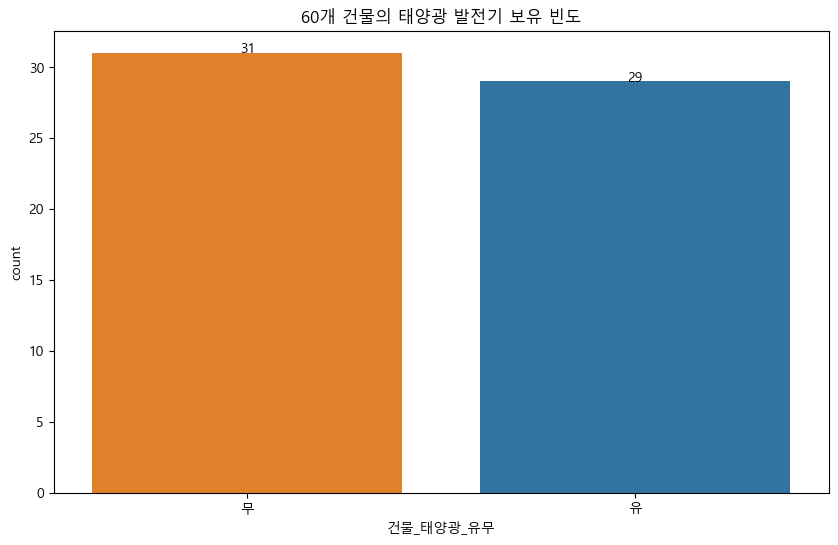

In [189]:
##### 태양광 변수에 대해서 조금 더 EDA
# 60개 건물의 태양광 발전기 보유 빈도 그래프
solar_generator_YorN = building_df.groupby('num', as_index=False)\
                                  .agg(건물_태양광_유무 = ('태양광보유', 'mean'))
solar_generator_YorN['건물_태양광_유무'] = solar_generator_YorN['건물_태양광_유무'].astype("object")
solar_generator_YorN.loc[solar_generator_YorN['건물_태양광_유무'] == 0, '건물_태양광_유무'] = '무'
solar_generator_YorN.loc[solar_generator_YorN['건물_태양광_유무'] == 1, '건물_태양광_유무'] = '유'

plt.figure(figsize=(10, 6))
ax = sns.countplot(data = solar_generator_YorN, x = '건물_태양광_유무', hue= '건물_태양광_유무', hue_order='유무')
for p in ax.patches:
    ax.text(p.get_x() + p.get_width() / 2, # x 좌표
            p.get_y() + p.get_height() , # y 좌표
            f"{p.get_height():.0f}", # 값
            ha='center') # 가운데 정렬
plt.title('60개 건물의 태양광 발전기 보유 빈도')
plt.show()

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000.]),
 [Text(0, 0.0, '0'),
  Text(0, 2000.0, '2000'),
  Text(0, 4000.0, '4000'),
  Text(0, 6000.0, '6000'),
  Text(0, 8000.0, '8000'),
  Text(0, 10000.0, '10000')])

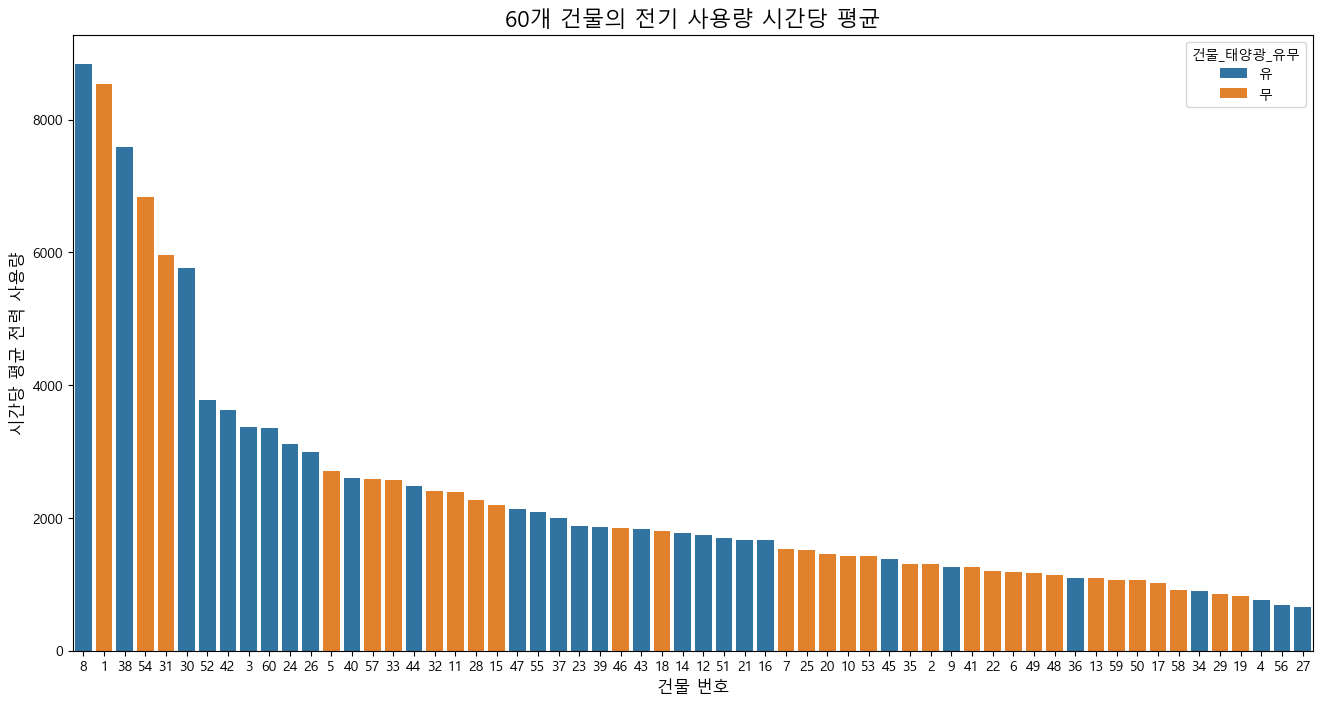

In [190]:
# 각 건물 별 전력 사용량 평균 그래프
elec_mean_df = building_df.groupby('num', as_index=False)\
                          .agg(mean_elec = ('전력사용량', 'mean'))\
                          .sort_values('mean_elec', ascending= False)
elec_mean_df = pd.merge(elec_mean_df, solar_generator_YorN, how = 'left', on = 'num')

plt.figure(figsize=(16, 8))
sns.barplot(data = elec_mean_df, x = 'num', y = 'mean_elec', order = elec_mean_df['num'], hue = '건물_태양광_유무', hue_order='유무')
plt.title('60개 건물의 전기 사용량 시간당 평균', fontsize=16) # 그래프 제목 추가 및 글자 크기 설정
plt.xlabel('건물 번호', fontsize=12)
plt.ylabel('시간당 평균 전력 사용량', fontsize=12)
plt.xticks(fontsize=10) # x축 레이블 글자 크기 설정
plt.yticks(fontsize=10) # y축 레이블 글자 크기 설정

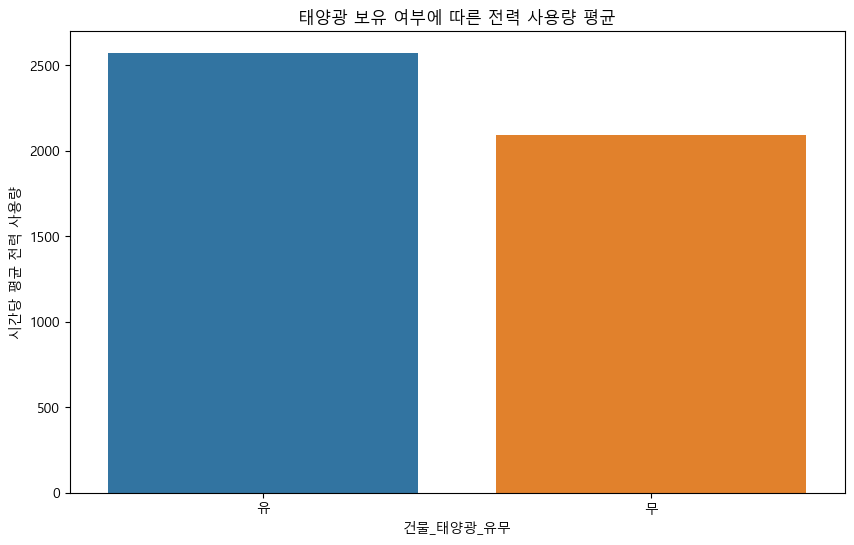

In [191]:
# 태양광 보유 유무에 따른 전력사용량
# Bar plot 시각화 (평균값)
my_df = elec_mean_df.groupby('건물_태양광_유무', as_index=False).agg(mean_elec = ('mean_elec', 'mean')).sort_values('mean_elec', ascending= False)

plt.figure(figsize=(10, 6))
sns.barplot(x='건물_태양광_유무', y='mean_elec', data=my_df, hue= '건물_태양광_유무', hue_order='유무')
plt.title('태양광 보유 여부에 따른 전력 사용량 평균')
plt.ylabel('시간당 평균 전력 사용량')
plt.show()

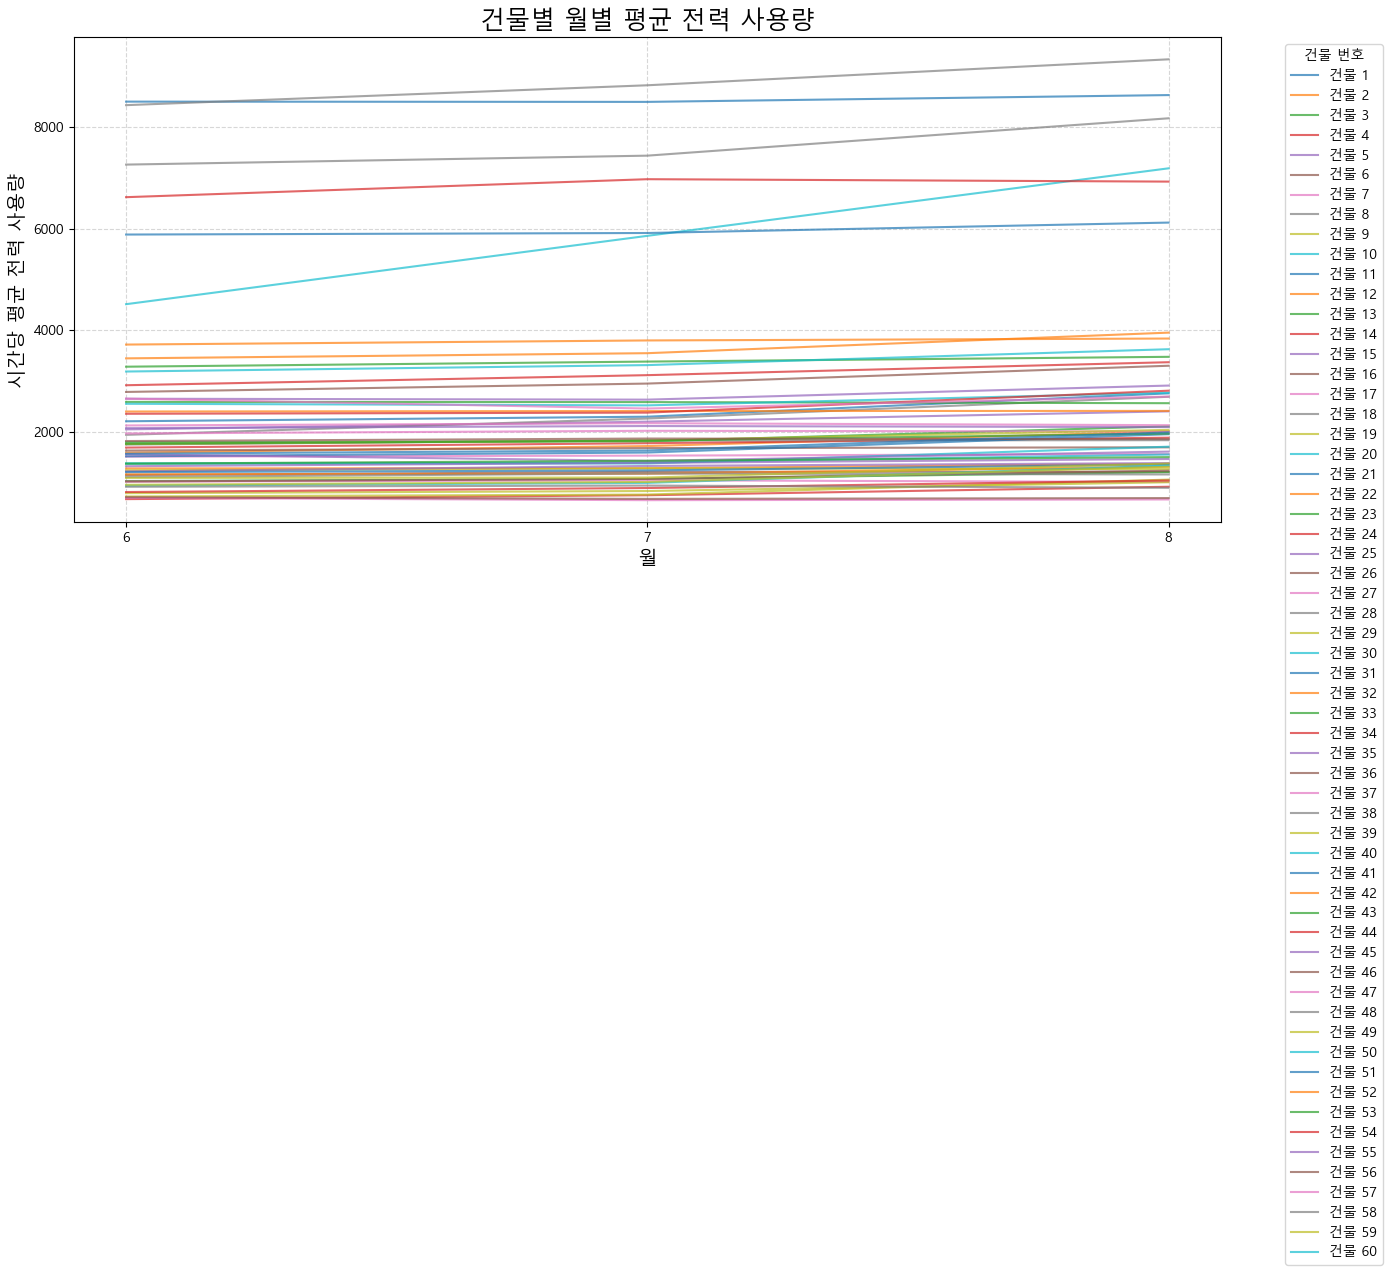

In [192]:
# 월별 전력사용량 건물별 평균 데이터 만들기
monthly_mean = building_df.groupby(['num', '월'])['전력사용량'].mean().reset_index()
monthly_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in monthly_mean['num'].unique():
    monthly_df = monthly_mean[monthly_mean['num'] == i]
    plt.plot(monthly_df['월'], monthly_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 월별 평균 전력 사용량', fontsize=18)
plt.xlabel('월', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(6,9))  # 세 개의 달 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

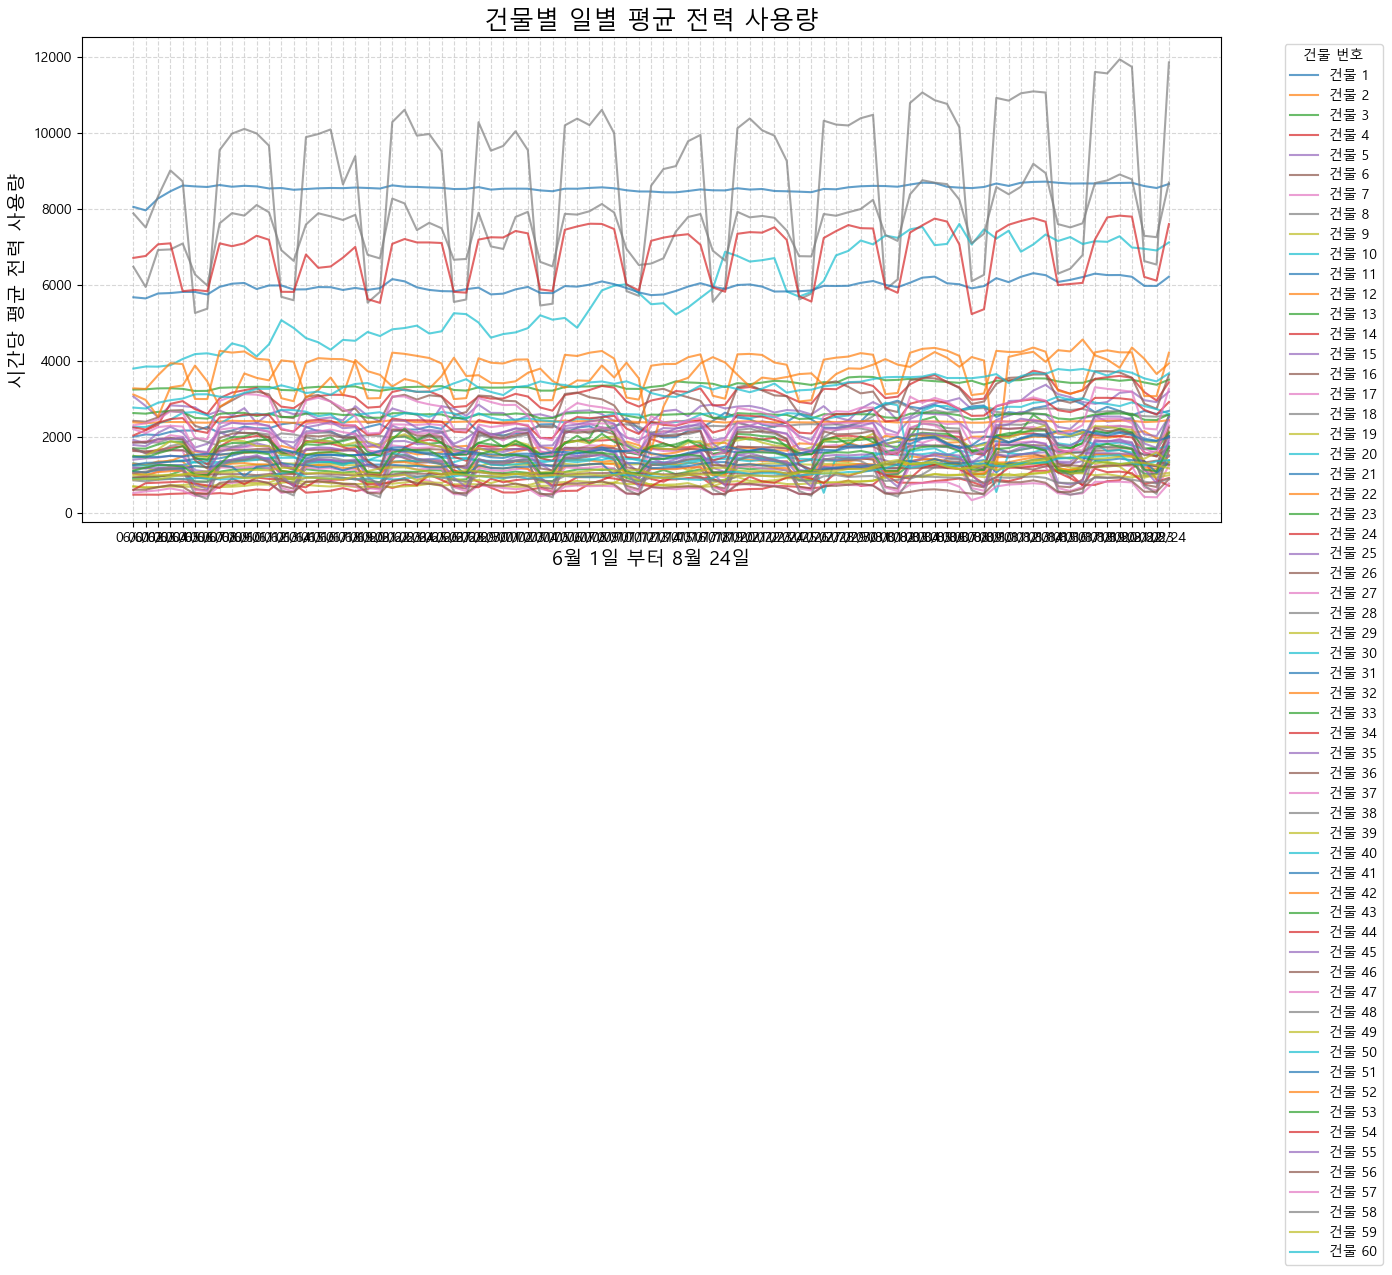

In [193]:
# 일별 전력사용량 건물별 평균 데이터 만들기
daily_mean = building_df.groupby(['num', '날짜'])['전력사용량'].mean().reset_index()
daily_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in daily_mean['num'].unique():
    daily_df = daily_mean[daily_mean['num'] == i]
    plt.plot(daily_df['날짜'], daily_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 일별 평균 전력 사용량', fontsize=18)
plt.xlabel('6월 1일 부터 8월 24일', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(0, 85))  # 0시부터 23시까지 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

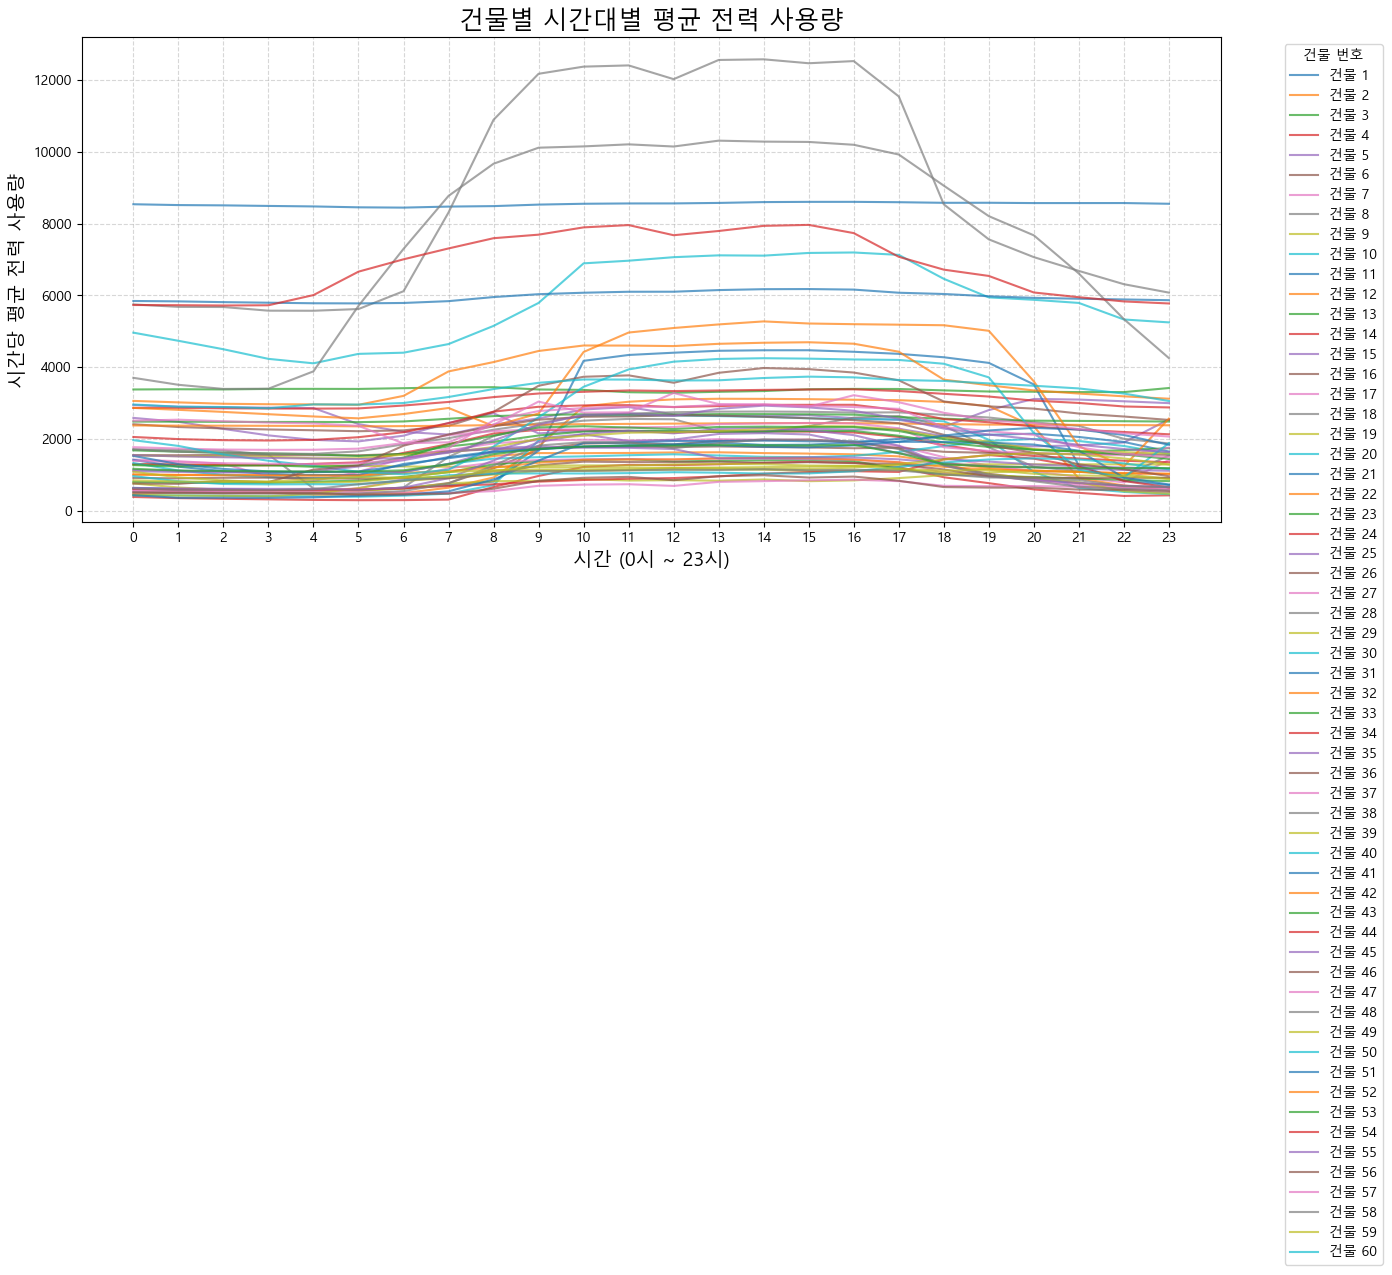

In [194]:
# 시간별 전력사용량 건물별 평균 데이터 만들기
hourly_mean = building_df.groupby(['num', '시'])['전력사용량'].mean().reset_index()
hourly_mean

# 그래프 설정
plt.figure(figsize=(14, 10))

# 각 건물의 평균 전력 사용량 시각화
for i in hourly_mean['num'].unique():
    hourly_df = hourly_mean[hourly_mean['num'] == i]
    plt.plot(hourly_df['시'], hourly_df['전력사용량'], label=f'건물 {i}', alpha=0.7)

# 그래프 꾸미기
plt.title('건물별 시간대별 평균 전력 사용량', fontsize=18)
plt.xlabel('시간 (0시 ~ 23시)', fontsize=14)
plt.ylabel('시간당 평균 전력 사용량', fontsize=14)
plt.xticks(range(0, 24))  # 0시부터 23시까지 x축 눈금
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='건물 번호', bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

## 기상청 청주 데이터 2개
### 전처리

In [195]:
# 데이터 불러오기
train_chungju = pd.read_csv('../data/train_chungju_new.csv', encoding='utf-8')
test_chungju = pd.read_csv('../data/test_2020.csv', encoding='utf-8')

In [196]:
# 변수명 변경
train_SolarEnergy = train_chungju.rename(columns={
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

test_SolarEnergy = test_chungju.rename(columns={
    '기온(°C)': '기온',
    '풍속(m/s)': '풍속',
    '습도(%)': '습도',
    '강수량(mm)': '강수량',
    '일조(hr)': '일조',
    '일사(MJ/m2)': '일사'
}, inplace=False)

print(train_SolarEnergy.columns)
print(test_SolarEnergy.columns)

Index(['일시', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')
Index(['일시', '기온', '강수량', '풍속', '습도', '일조', '일사'], dtype='object')


In [197]:
train_SolarEnergy.head()

,일시,기온,강수량,풍속,습도,일조,일사
0,2017-01-01 00:00,2.4,NaN,0.5,78,NaN,NaN
1,2017-01-01 01:00,2.2,NaN,0.2,78,NaN,NaN
2,2017-01-01 02:00,1.9,NaN,0.5,80,NaN,NaN
3,2017-01-01 03:00,1.1,NaN,0.5,83,NaN,NaN
4,2017-01-01 04:00,1.0,NaN,0.0,84,NaN,NaN


In [198]:
train_SolarEnergy.shape

(29927, 7)

In [199]:
test_SolarEnergy.head()

,일시,기온,강수량,풍속,습도,일조,일사
0,2020-06-01 00:00,20.7,0.0,0.8,65.0,NaN,NaN
1,2020-06-01 01:00,18.1,0.0,1.1,87.0,NaN,NaN
2,2020-06-01 02:00,18.0,0.1,0.8,91.0,NaN,NaN
3,2020-06-01 03:00,18.0,0.5,1.1,92.0,NaN,NaN
4,2020-06-01 04:00,18.2,0.0,1.1,91.0,NaN,NaN


In [200]:
test_SolarEnergy.shape

(2040, 7)

In [201]:
### 데이터 타입 변경
# 청주 train 데이터
train_SolarEnergy.info()
train_SolarEnergy['일시'] = pd.to_datetime(train_SolarEnergy['일시']) # datetime 형식으로 변환
print(train_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29927 entries, 0 to 29926
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      29927 non-null  object 
 1   기온      29927 non-null  float64
 2   강수량     2702 non-null   float64
 3   풍속      29926 non-null  float64
 4   습도      29927 non-null  int64  
 5   일조      16352 non-null  float64
 6   일사      16345 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 1.6+ MB
일시     datetime64[ns]
기온            float64
강수량           float64
풍속            float64
습도              int64
일조            float64
일사            float64
dtype: object


In [202]:
# 청주 test 데이터
test_SolarEnergy.info()
test_SolarEnergy['일시'] = pd.to_datetime(test_SolarEnergy['일시']) # datetime 형식으로 변환
print(test_SolarEnergy.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2040 entries, 0 to 2039
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   일시      2040 non-null   object 
 1   기온      2040 non-null   float64
 2   강수량     518 non-null    float64
 3   풍속      2040 non-null   float64
 4   습도      2038 non-null   float64
 5   일조      1275 non-null   float64
 6   일사      1275 non-null   float64
dtypes: float64(6), object(1)
memory usage: 111.7+ KB
일시     datetime64[ns]
기온            float64
강수량           float64
풍속            float64
습도            float64
일조            float64
일사            float64
dtype: object


In [203]:
train_SolarEnergy.describe()

,일시,기온,강수량,풍속,습도,일조,일사
count,29927,29927.000000,2702.000000,29926.000000,29927.000000,16352.000000,16345.000000
mean,2018-09-16 11:55:31.626958848,13.213246,1.394523,1.528106,59.238514,0.542191,1.122335
min,2017-01-01 00:00:00,-15.600000,0.000000,0.000000,10.000000,0.000000,0.000000
25%,2017-11-08 18:30:00,4.100000,0.000000,0.800000,44.000000,0.000000,0.240000
50%,2018-09-16 12:00:00,13.600000,0.100000,1.400000,60.000000,0.700000,0.910000
75%,2019-07-25 05:30:00,22.300000,1.200000,2.100000,75.000000,1.000000,1.830000
max,2020-05-31 23:00:00,38.100000,86.200000,7.700000,100.000000,1.000000,3.800000
std,NaN,10.784507,4.277216,0.972506,19.682066,0.447674,0.972006


In [204]:
test_SolarEnergy.describe()

,일시,기온,강수량,풍속,습도,일조,일사
count,2040,2040.000000,518.000000,2040.000000,2038.000000,1275.000000,1275.000000
mean,2020-07-13 11:30:00,25.223775,1.590347,1.470245,73.354269,0.324941,1.128447
min,2020-06-01 00:00:00,15.900000,0.000000,0.000000,19.000000,0.000000,0.040000
25%,2020-06-22 05:45:00,22.700000,0.000000,0.900000,63.000000,0.000000,0.260000
50%,2020-07-13 11:30:00,25.100000,0.100000,1.400000,76.000000,0.000000,0.770000
75%,2020-08-03 17:15:00,27.500000,1.375000,1.900000,86.000000,0.800000,1.810000
max,2020-08-24 23:00:00,34.000000,34.200000,5.200000,96.000000,1.000000,3.860000
std,NaN,3.413885,3.495859,0.803219,14.982304,0.410045,1.025027


In [205]:
## 태양에너지 트레인 데이터
train_SolarEnergy.isna().sum()
train_SolarEnergy[train_SolarEnergy['풍속'].isna()] # 20971 번째 행이 문제.

# 날씨는 이어진다. 그 사이 데이터를 보자.
train_SolarEnergy.iloc[20961: 20981, :] # 그 전 후 1시간동안 2.5였음.

,일시,기온,강수량,풍속,습도,일조,일사
20961,2019-05-24 10:00:00,26.7,NaN,1.6,41,1.0,2.48
20962,2019-05-24 11:00:00,27.8,NaN,2.5,35,1.0,3.04
20963,2019-05-24 12:00:00,29.0,NaN,1.9,37,1.0,3.38
20964,2019-05-24 13:00:00,30.8,NaN,1.9,34,1.0,3.77
20965,2019-05-24 14:00:00,32.4,NaN,2.4,33,1.0,3.35
20966,2019-05-24 15:00:00,32.2,NaN,2.0,33,1.0,3.01
20967,2019-05-24 16:00:00,32.3,NaN,2.0,33,1.0,2.50
20968,2019-05-24 17:00:00,32.2,NaN,2.6,33,1.0,1.83
20969,2019-05-24 18:00:00,31.5,NaN,2.1,36,1.0,1.12
20970,2019-05-24 19:00:00,29.7,NaN,2.5,41,0.6,0.44


In [206]:
# 똑같이 2.5(m/s)로 처리하자.
train_SolarEnergy.loc[20971, '풍속'] = 2.5

# 강수량, 일조, 일사는. 비가 안 왔을 때, 해가 뜨지 않았을 때 값이 없는 것으로 판단.
# 전부 0으로 처리
train_SolarEnergy.fillna(0, inplace=True)
train_SolarEnergy.isna().sum()

일시     0
기온     0
강수량    0
풍속     0
습도     0
일조     0
일사     0
dtype: int64

In [207]:
## 태양에너지 테스트 데이터
test_SolarEnergy.isna().sum()
test_SolarEnergy[test_SolarEnergy['습도'].isna()] # 673, 674 번째 행이 문제.
# 2020-06-29 1시와 2시에 습도 데이터가 없는 거구나!

# 날씨는 이어진다. 그 사이 데이터를 보자.
test_SolarEnergy.iloc[663: 684, :] # 2시간 사이에 64.0 에서 82.0으로 바뀌었다!

,일시,기온,강수량,풍속,습도,일조,일사
663,2020-06-28 15:00:00,29.6,NaN,2.4,47.0,0.9,2.93
664,2020-06-28 16:00:00,29.9,NaN,2.3,46.0,0.9,2.40
665,2020-06-28 17:00:00,30.2,NaN,2.1,45.0,1.0,2.09
666,2020-06-28 18:00:00,29.5,NaN,1.7,46.0,1.0,1.33
667,2020-06-28 19:00:00,28.2,NaN,2.1,49.0,1.0,0.66
668,2020-06-28 20:00:00,26.7,NaN,1.7,55.0,0.2,0.15
669,2020-06-28 21:00:00,25.8,NaN,1.2,59.0,NaN,NaN
670,2020-06-28 22:00:00,25.2,NaN,0.5,59.0,NaN,NaN
671,2020-06-28 23:00:00,25.0,NaN,1.0,60.0,NaN,NaN
672,2020-06-29 00:00:00,24.1,NaN,0.8,64.0,NaN,NaN


In [208]:
# 한 시간에 6%씩 습도가 오른거로 치자.
test_SolarEnergy.loc[673, '습도'] = 70
test_SolarEnergy.loc[674, '습도'] = 76

# 강수량, 일조, 일사는. 비가 안 왔을 때, 해가 뜨지 않았을 때 값이 없는 것으로 판단.
# 전부 0으로 처리
test_SolarEnergy.fillna(0, inplace= True)
test_SolarEnergy.isna().sum()

일시     0
기온     0
강수량    0
풍속     0
습도     0
일조     0
일사     0
dtype: int64

In [209]:
### 2017-04-03 23:00 행이 없음!!
train_SolarEnergy.query('일시 == "2017-04-03 22:00"')
train_SolarEnergy.query('일시 == "2017-04-03 23:00"')
train_SolarEnergy.query('일시 == "2017-04-04 00:00"')

missing_hour = pd.DataFrame({
    "일시": ["2017-04-03 23:00"],
    "기온": [(13.2 + 11.4) / 2],
    "강수량": [0],
    "풍속": [(1.7 + 0.6) / 2],
    "습도": [(23 + 30) / 2],
    "일조": [0],
    "일사": [0]
})
train_SolarEnergy = pd.concat([train_SolarEnergy, missing_hour], ignore_index=True)

train_SolarEnergy['일시'] = pd.to_datetime(train_SolarEnergy['일시'])

# '일시' 열을 기준으로 정렬하고 인덱스 재설정
train_SolarEnergy = train_SolarEnergy.sort_values(by='일시').reset_index(drop=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1981381273.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_SolarEnergy.query('일시 == "2017-04-03 22:00"')
C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1981381273.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_SolarEnergy.query('일시 == "2017-04-03 23:00"')
C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1981381273.py:4: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicit

### 파생변수 추가

In [210]:
### 시간 관련된 파생변수 추가
train_SolarEnergy['year'] = train_SolarEnergy['일시'].dt.year
train_SolarEnergy['month'] = train_SolarEnergy['일시'].dt.month
train_SolarEnergy['hour'] = train_SolarEnergy['일시'].dt.hour

test_SolarEnergy['year'] = test_SolarEnergy['일시'].dt.year
test_SolarEnergy['month'] = test_SolarEnergy['일시'].dt.month
test_SolarEnergy['hour'] = test_SolarEnergy['일시'].dt.hour

In [211]:
# '일시' 열을 인덱스로 설정하여 시간 순서에 따라 정렬
train_SolarEnergy.set_index('일시', inplace= True)
test_SolarEnergy.set_index('일시', inplace= True)
train_SolarEnergy.head()

,기온,강수량,풍속,습도,일조,일사,year,month,hour
일시,,,,,,,,,
2017-01-01 00:00:00,2.4,0.0,0.5,78.0,0.0,0.0,2017,1,0
2017-01-01 01:00:00,2.2,0.0,0.2,78.0,0.0,0.0,2017,1,1
2017-01-01 02:00:00,1.9,0.0,0.5,80.0,0.0,0.0,2017,1,2
2017-01-01 03:00:00,1.1,0.0,0.5,83.0,0.0,0.0,2017,1,3
2017-01-01 04:00:00,1.0,0.0,0.0,84.0,0.0,0.0,2017,1,4


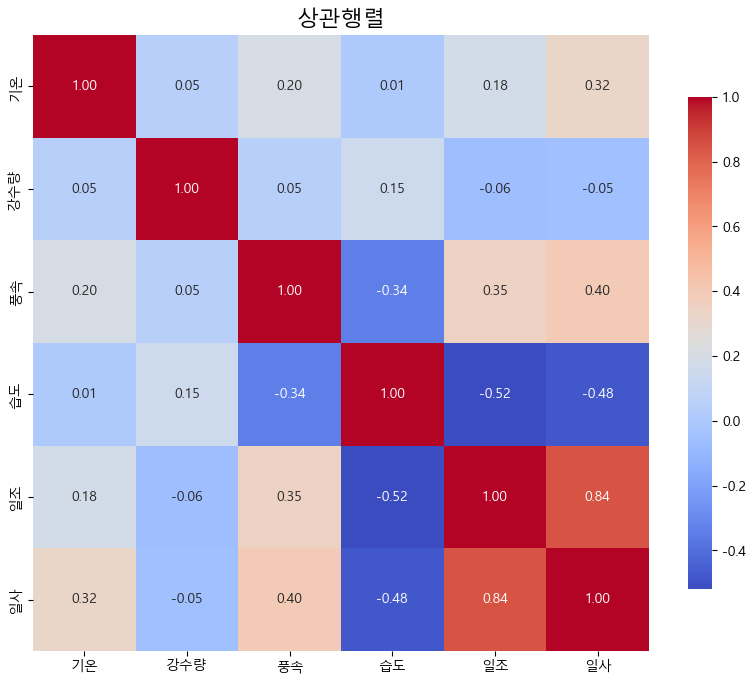

In [212]:
# 상관행렬 

# 관심 있는 열을 선택하여 상관행렬 계산
correlation_matrix = train_SolarEnergy[['기온', '강수량', '풍속', '습도', '일조', '일사']].corr()

# 상관행렬 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True, cbar_kws={"shrink": .8})
plt.title('상관행렬', fontsize=16)
plt.show()

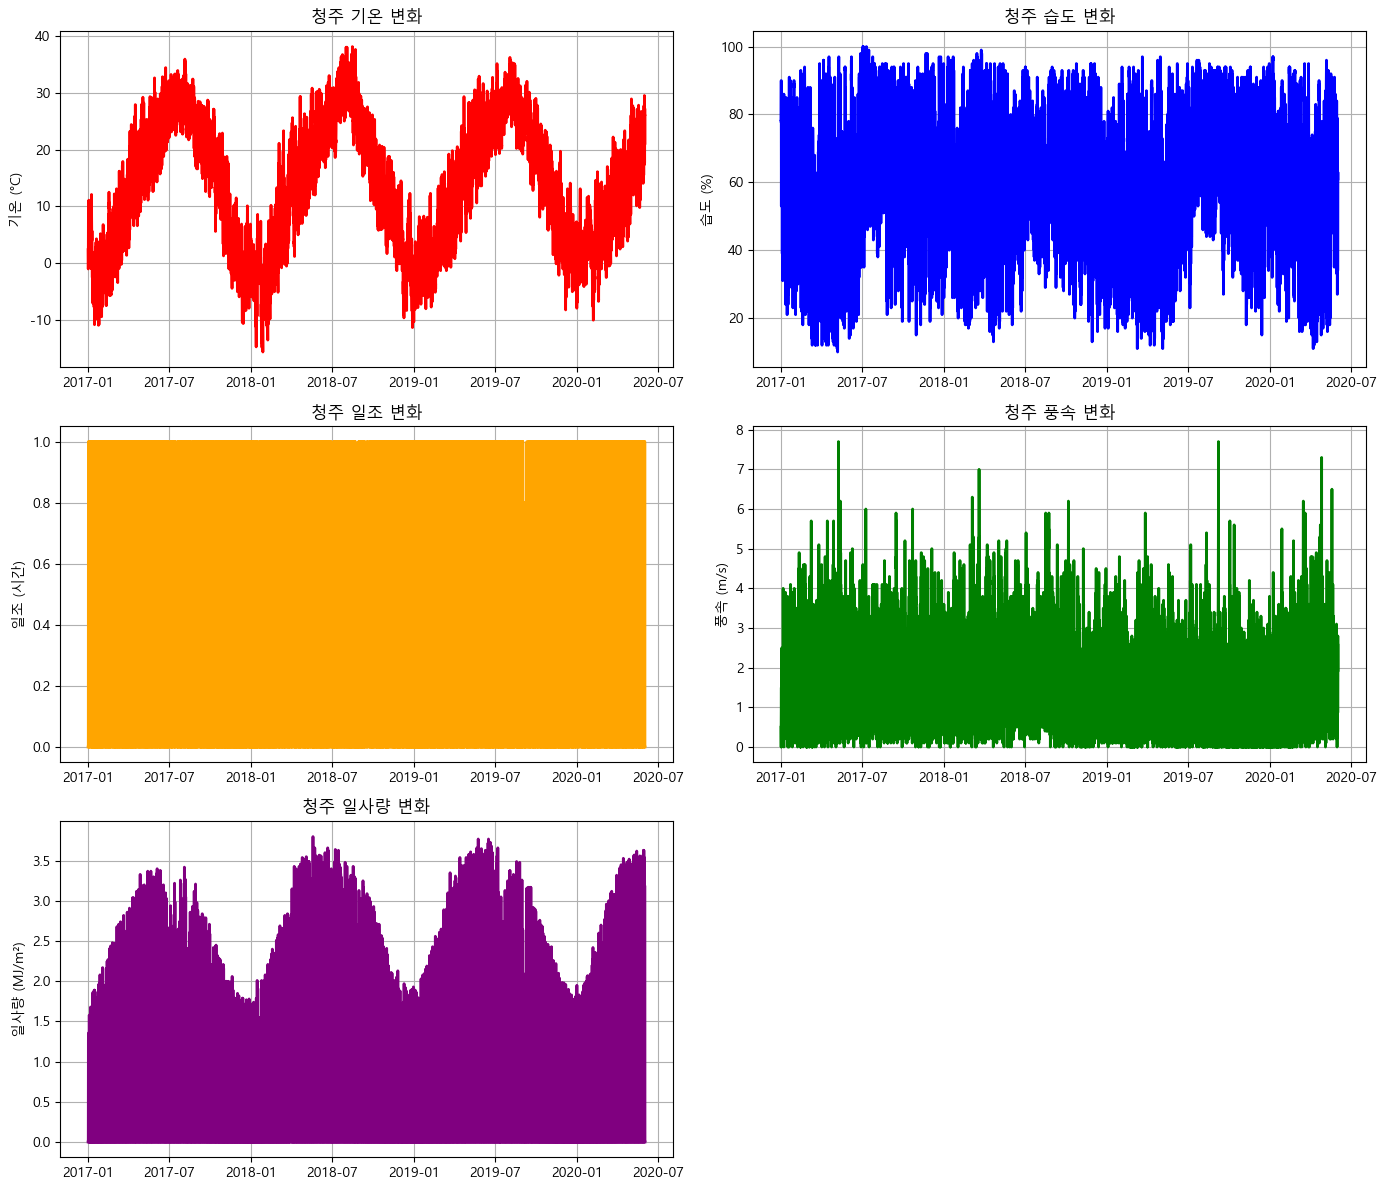

In [213]:
# 서브플롯 설정 (3행 2열로 구성)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# 기온 변화
axes[0, 0].plot(train_SolarEnergy.index, train_SolarEnergy['기온'], color='red', label='기온', linewidth=2)
axes[0, 0].set_title('청주 기온 변화', fontsize=12)
axes[0, 0].set_ylabel('기온 (°C)', fontsize=10)
axes[0, 0].grid(True)

# 습도 변화
axes[0, 1].plot(train_SolarEnergy.index, train_SolarEnergy['습도'], color='blue', label='습도', linewidth=2)
axes[0, 1].set_title('청주 습도 변화', fontsize=12)
axes[0, 1].set_ylabel('습도 (%)', fontsize=10)
axes[0, 1].grid(True)

# 일조 변화
axes[1, 0].plot(train_SolarEnergy.index, train_SolarEnergy['일조'], color='orange', label='일조', linewidth=2)
axes[1, 0].set_title('청주 일조 변화', fontsize=12)
axes[1, 0].set_ylabel('일조 (시간)', fontsize=10)
axes[1, 0].grid(True)

# 풍속 변화
axes[1, 1].plot(train_SolarEnergy.index, train_SolarEnergy['풍속'], color='green', label='풍속', linewidth=2)
axes[1, 1].set_title('청주 풍속 변화', fontsize=12)
axes[1, 1].set_ylabel('풍속 (m/s)', fontsize=10)
axes[1, 1].grid(True)

# 일사량 변화
axes[2, 0].plot(train_SolarEnergy.index, train_SolarEnergy['일사'], color='purple', label='일사량', linewidth=2)
axes[2, 0].set_title('청주 일사량 변화', fontsize=12)
axes[2, 0].set_ylabel('일사량 (MJ/m²)', fontsize=10)
axes[2, 0].grid(True)

# 빈 서브플롯 비워두기 (2행 2열에서 하나 비워두기)
axes[2, 1].axis('off')

# 그래프 간격 조정
plt.tight_layout()
plt.show()

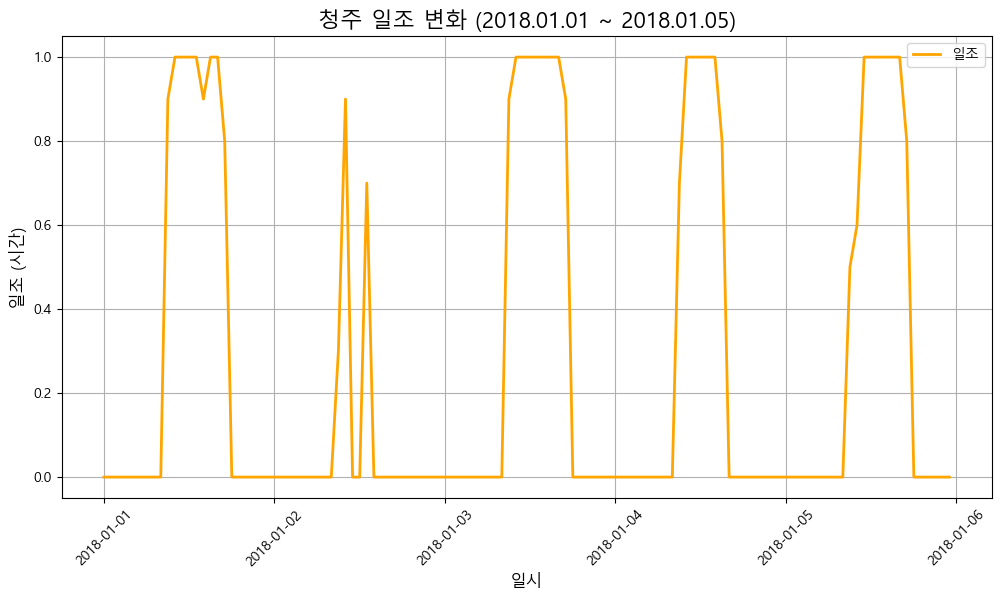

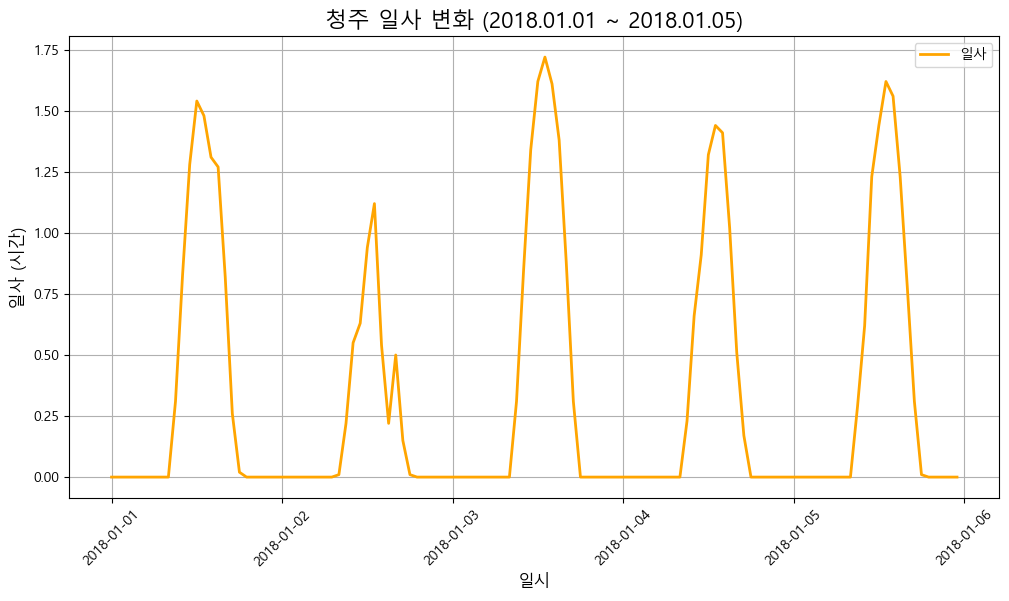

In [214]:
### 청주 일조 변화
# 특정 기간 설정 (예: 2018년 1월부터 3월까지)
start_date = '2018-01-01'
end_date = '2018-01-05'

# 특정 기간에 해당하는 데이터 필터링
subset_train1 = train_SolarEnergy.loc[start_date:end_date]

# 일조 데이터를 리스트로 변환
일조_리스트 = subset_train1['일조'].tolist()

# 일시 데이터와 일조 데이터를 함께 시각화
plt.figure(figsize=(12, 6))
plt.plot(subset_train1.index, 일조_리스트, color='orange', label='일조', linewidth=2)
plt.title('청주 일조 변화 (2018.01.01 ~ 2018.01.05)', fontsize=16)
plt.xlabel('일시', fontsize=12)
plt.ylabel('일조 (시간)', fontsize=12)
plt.xticks(rotation=45)  # x축 날짜 각도 조정
plt.grid(True)
plt.legend()
plt.show()

### 청주 일사 변화
# 특정 기간 설정 (예: 2018년 1월부터 3월까지)
start_date = '2018-01-01'
end_date = '2018-01-05'

# 특정 기간에 해당하는 데이터 필터링
subset_train2 = train_SolarEnergy.loc[start_date:end_date]

# 일사 데이터를 리스트로 변환
일사_리스트 = subset_train2['일사'].tolist()

# 일시 데이터와 일사 데이터를 함께 시각화
plt.figure(figsize=(12, 6))
plt.plot(subset_train2.index, 일사_리스트, color='orange', label='일사', linewidth=2)
plt.title('청주 일사 변화 (2018.01.01 ~ 2018.01.05)', fontsize=16)
plt.xlabel('일시', fontsize=12)
plt.ylabel('일사 (시간)', fontsize=12)
plt.xticks(rotation=45)  # x축 날짜 각도 조정
plt.grid(True)
plt.legend()
plt.show()

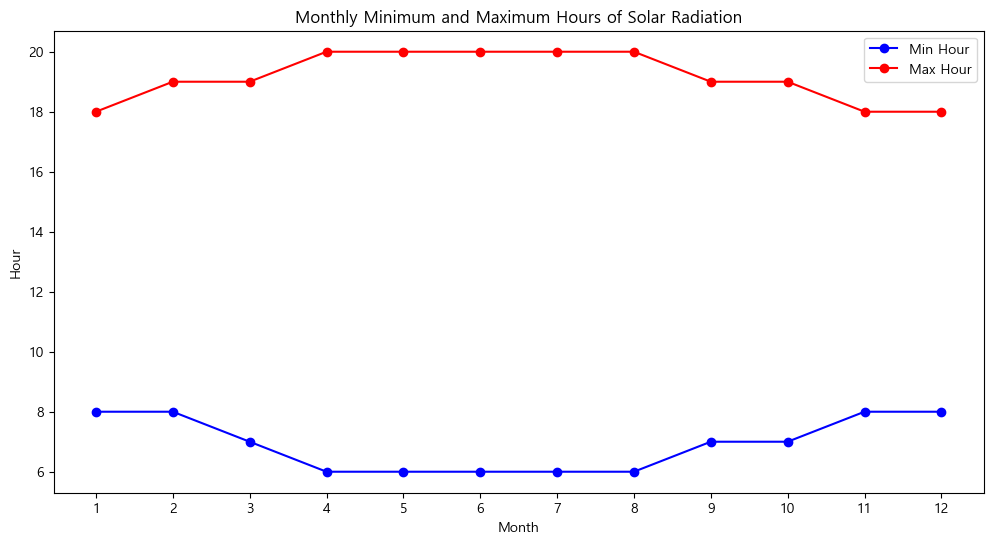

In [215]:
result = train_SolarEnergy.query('일사 > 0').groupby('month', as_index=False).agg(
    min_hour=('hour', 'min'),
    max_hour=('hour', 'max')
)

plt.figure(figsize=(12, 6))
plt.plot(result['month'], result['min_hour'], marker='o', label='Min Hour', color='blue')
plt.plot(result['month'], result['max_hour'], marker='o', label='Max Hour', color='red')
plt.xlabel('Month')
plt.ylabel('Hour')
plt.title('Monthly Minimum and Maximum Hours of Solar Radiation')
plt.xticks(result['month'])
plt.legend()
plt.show()

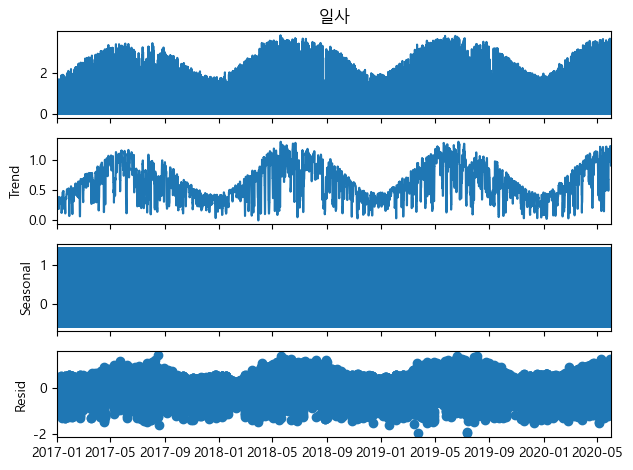

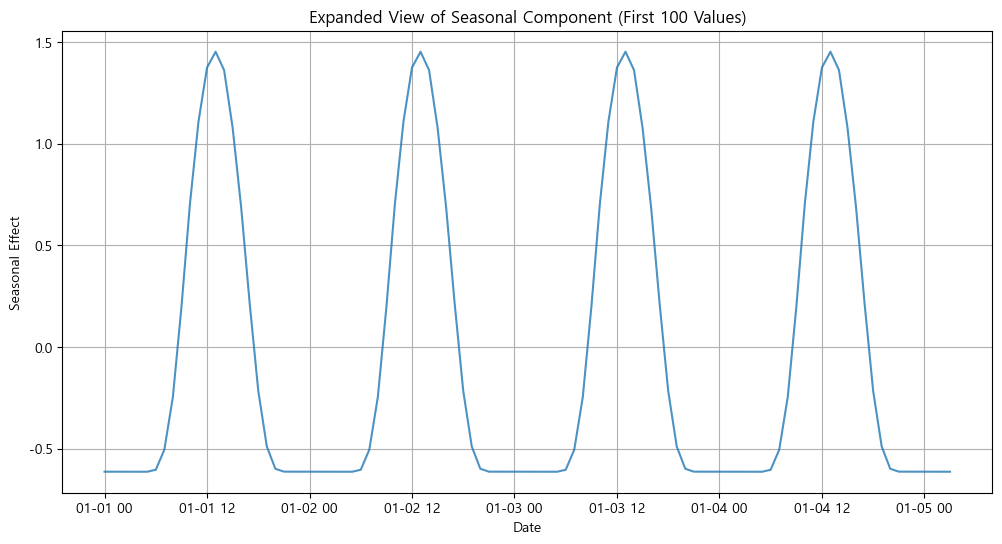

In [216]:
# 시계열 분해: 주기를 24로 설정해 일간 패턴 분석
result = seasonal_decompose(train_SolarEnergy['일사'], model='additive', period=24)

# 분해된 시계열 시각화
result.plot()
plt.show()

# 트렌드 0.05오른게 유의미한가
#시즈널 확대해보고 둘 다 보여주기. 

# Seasonal 컴포넌트에서 처음 100개만 추출
seasonal_data = result.seasonal[:100]

# 추출한 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(seasonal_data, linestyle='-', linewidth=1.5, alpha=0.8)
plt.title('Expanded View of Seasonal Component (First 100 Values)')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.grid(True)
plt.show()


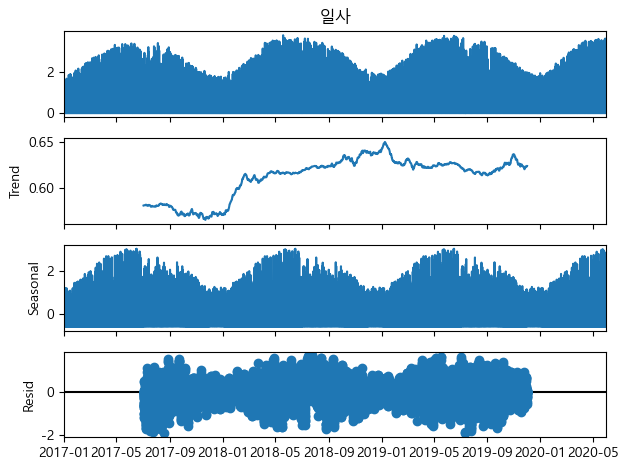

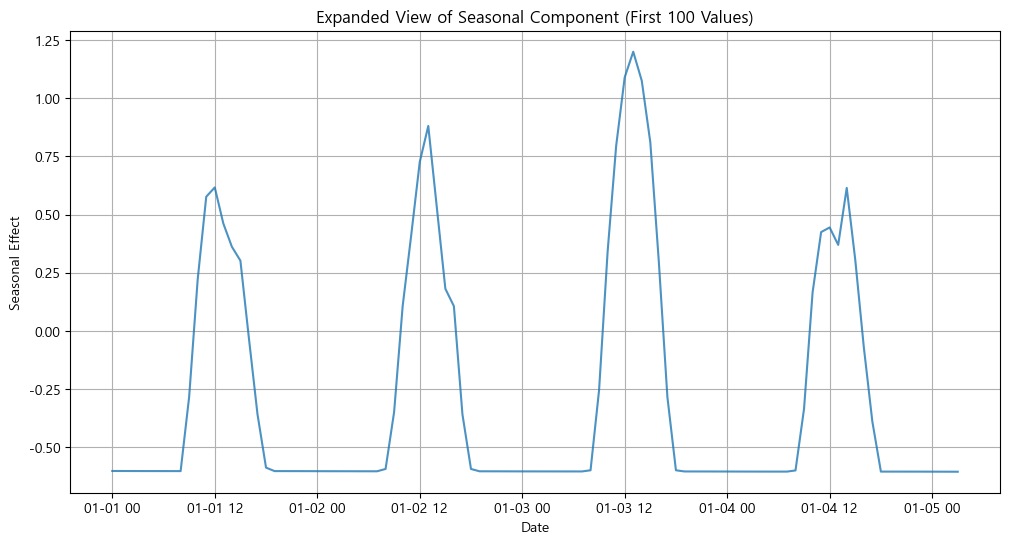

In [217]:
# 시계열 분해: 주기를 365 * 24로 설정해 연간 패턴 분석
result = seasonal_decompose(train_SolarEnergy['일사'], model='additive', period=8760)

# 분해된 시계열 시각화
result.plot()
plt.show()

# 트렌드 0.05오른게 유의미한가
#시즈널 확대해보고 둘 다 보여주기. 

# Seasonal 컴포넌트에서 처음 100개만 추출
seasonal_data = result.seasonal[:100]

# 추출한 데이터 시각화
plt.figure(figsize=(12, 6))
plt.plot(seasonal_data, linestyle='-', linewidth=1.5, alpha=0.8)
plt.title('Expanded View of Seasonal Component (First 100 Values)')
plt.xlabel('Date')
plt.ylabel('Seasonal Effect')
plt.grid(True)
plt.show()

In [218]:
# 정상성 테스트 (사리마 하려면 필요)
from statsmodels.tsa.stattools import adfuller

# ADF 테스트 함수 정의
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
    if result[1] <= 0.05:
        print("시계열 데이터는 정상입니다.")
    else:
        print("시계열 데이터는 비정상입니다.")

# '일사' 열에 대해 ADF 테스트 수행
adf_test(train_SolarEnergy['일사'])

# 정상임 -> 그래서 차분을 나타내는 d를 1로 설정

ADF Statistic: -13.441623
p-value: 0.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
시계열 데이터는 정상입니다.


In [219]:
# 사리마 모델 수행. 오래걸림. 노트북 기준 11분

from statsmodels.tsa.statespace.sarimax import SARIMAX

# SARIMA 모델 설정 (p, d, q) * (P, D, Q, S)
model = SARIMAX(train_SolarEnergy['일사'], order=(7, 1, 5), seasonal_order=(2, 1, 2, 24))
model_fit = model.fit()

# 예측 수행
forecast_steps = 120
forecast = model_fit.forecast(steps=forecast_steps)

# 예측 데이터를 데이터프레임으로 변환하여 날짜별로 그룹화
forecast_dates = pd.date_range(start=train_SolarEnergy.index[-1], periods=forecast_steps+1, freq='H')[1:]
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# 일별로 그룹화하여 통계 요약 정보 출력
daily_forecast_summary = forecast_df.groupby(forecast_df['Date'].dt.date)['Forecast'].agg(['mean', 'min', 'max', 'median'])

print(daily_forecast_summary)

c:\DS\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\DS\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
c:\DS\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\DS\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                mean       min       max    median
Date                                              
2020-06-01  0.980669 -0.002295  2.861778  0.394881
2020-06-02  1.004381  0.100305  2.850886  0.409499
2020-06-03  1.010237  0.114545  2.858002  0.413681
2020-06-04  1.015940  0.120323  2.864969  0.418979
2020-06-05  1.021089  0.124728  2.870776  0.424175


C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1098597022.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start=train_SolarEnergy.index[-1], periods=forecast_steps+1, freq='H')[1:]


C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1472021715.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  plt.plot(pd.date_range(start=train_SolarEnergy.index[-1], periods=forecast_steps+1, freq='H')[1:], forecast, label='Forecast', color='red')


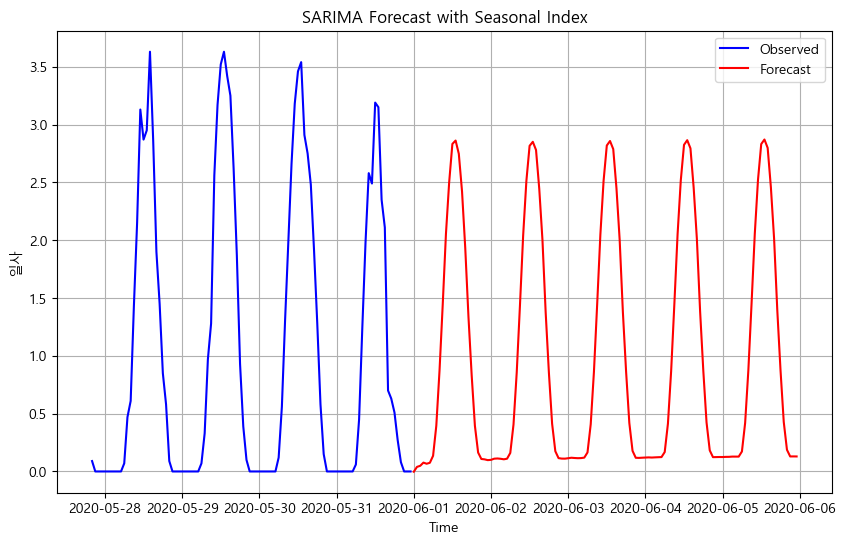

In [220]:
# 예측 결과 시각화
plt.figure(figsize=(10, 6))
plt.plot(train_SolarEnergy.index[-100:], train_SolarEnergy['일사'][-100:], label='Observed', color='blue')
plt.plot(pd.date_range(start=train_SolarEnergy.index[-1], periods=forecast_steps+1, freq='H')[1:], forecast, label='Forecast', color='red')
plt.title('SARIMA Forecast with Seasonal Index')
plt.xlabel('Time')
plt.ylabel('일사')
plt.legend()
plt.grid(True)
plt.show()

#sarima 는 y만 써서 x들의 정보를 사용하지 못함.
# 일사량은 구름, 온도, ,,,, 영향을 받을텐데 활용 못하는 단점.

In [221]:
# Feature와 Target 분리
X_train = train_SolarEnergy.drop(['일사'], axis=1)
y_train = train_SolarEnergy['일사']
X_test = test_SolarEnergy.drop(['일사'], axis=1)
y_test = test_SolarEnergy['일사']

### 모델 만들기

In [222]:
# 모델 학습 및 예측 함수
def train_and_evaluate_model(model_name, X_train_data, y_train_data, X_test_data, y_test_data, is_lstm=False):
    if is_lstm:
        model_name.fit(X_train_data, y_train_data, epochs=10, batch_size=32, verbose=1)
        test_predict = model_name.predict(X_test_data).flatten()
    else:
        model_name.fit(X_train_data, y_train_data)
        test_predict = model_name.predict(X_test_data)
    
    train_predict = model_name.predict(X_train_data) if not is_lstm else model_name.predict(X_train_data).flatten()
    
    mae_test = mean_absolute_error(y_test_data, test_predict)
    rmse_test = np.sqrt(mean_squared_error(y_test_data, test_predict))
    
    print(f"Test - MAE: {mae_test:.5f}, RMSE: {rmse_test:.5f}")
    return test_predict

In [223]:
# Linear Regression
print("Linear Regression Results")
linear_model = LinearRegression()
linear_pred = train_and_evaluate_model(linear_model, X_train, y_train, X_test, y_test)

Linear Regression Results
Test - MAE: 0.41063, RMSE: 0.53095


In [224]:
# Decision Tree Regressor
print("\nDecision Tree Regressor Results")
tree_model = DecisionTreeRegressor(random_state=42)
tree_pred = train_and_evaluate_model(tree_model, X_train, y_train, X_test, y_test)


Decision Tree Regressor Results
Test - MAE: 0.12689, RMSE: 0.23214


In [225]:
# Random Forest Regressor
print("\nRandom Forest Regressor Results")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pred = train_and_evaluate_model(rf_model, X_train, y_train, X_test, y_test)


Random Forest Regressor Results
Test - MAE: 0.09018, RMSE: 0.16290


In [226]:
# Gradient Boosting Regressor
print("\nGradient Boosting Regressor Results")
gb_model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gb_pred = train_and_evaluate_model(gb_model, X_train, y_train, X_test, y_test)


Gradient Boosting Regressor Results
Test - MAE: 0.14619, RMSE: 0.21486


In [227]:
# LightGBM Regressor
print("\nLightGBM Regressor Results")
lgbm_model = LGBMRegressor(n_estimators=100, random_state=42, verbose=0)
lgbm_pred = train_and_evaluate_model(lgbm_model, X_train, y_train, X_test, y_test)


LightGBM Regressor Results
Test - MAE: 0.09005, RMSE: 0.15402


In [228]:
# CatBoost Regressor
print("\nCatBoost Regressor Results")
catboost_model = CatBoostRegressor(iterations=1000, learning_rate=0.1, depth=6, random_seed=42,verbose=100)
catboost_pred = train_and_evaluate_model(catboost_model, X_train, y_train, X_test, y_test)


CatBoost Regressor Results
0:	learn: 0.8307339	total: 9.95ms	remaining: 9.94s
100:	learn: 0.1397236	total: 342ms	remaining: 3.04s
200:	learn: 0.1287312	total: 674ms	remaining: 2.68s
300:	learn: 0.1230727	total: 990ms	remaining: 2.3s
400:	learn: 0.1193094	total: 1.29s	remaining: 1.93s
500:	learn: 0.1163969	total: 1.61s	remaining: 1.6s
600:	learn: 0.1139378	total: 1.94s	remaining: 1.29s
700:	learn: 0.1117906	total: 2.29s	remaining: 976ms
800:	learn: 0.1099312	total: 2.62s	remaining: 652ms
900:	learn: 0.1084558	total: 3.01s	remaining: 330ms
999:	learn: 0.1070913	total: 3.37s	remaining: 0us
Test - MAE: 0.09885, RMSE: 0.15726


In [229]:
# LSTM Model
def create_sequences(X, Y, time_step=1):
    X_seq, Y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step)])
        Y_seq.append(Y[i + time_step])
    return np.array(X_seq), np.array(Y_seq)

X_seq_train, y_seq_train = create_sequences(X_train, y_train, time_step=24)
X_seq_test, y_seq_test = create_sequences(X_test, y_test, time_step=24)

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

print("\nLSTM Results")
lstm_model = create_lstm_model((X_seq_train.shape[1], X_seq_train.shape[2]))
lstm_pred = train_and_evaluate_model(lstm_model, X_seq_train, y_seq_train, X_seq_test, y_seq_test, is_lstm=True)

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\3741794155.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Y_seq.append(Y[i + time_step])



LSTM Results
Epoch 1/10


c:\DS\Python\Python312\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 26079.6816
Epoch 2/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 233.1927
Epoch 3/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 184.6134
Epoch 4/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 84.4118
Epoch 5/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 268.4529
Epoch 6/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.1463
Epoch 7/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 1.0466
Epoch 8/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.9668
Epoch 9/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9569
Epoch 10/10
935/935 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.9868
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
935/935 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Test - MAE: 1.09228, RMSE: 1.20697


Linear Regression Results
Test - MAE: 0.41063, RMSE: 0.53095

Decision Tree Regressor Results
Test - MAE: 0.12689, RMSE: 0.23214

Random Forest Regressor Results
Test - MAE: 0.09018, RMSE: 0.16290

Gradient Boosting Regressor Results
Test - MAE: 0.14619, RMSE: 0.21486

LightGBM Regressor Results
Test - MAE: 0.09005, RMSE: 0.15402

CatBoost Regressor Results
Test - MAE: 0.09885, RMSE: 0.15726

LSTM Results
Test - MAE: 1.90462, RMSE: 2.34075


### LightGBM 모델이 일사 예측을 가장 잘 한다

In [230]:
# 그림그리기 위해서 인덱스 리셋.
train_SolarEnergy.reset_index(inplace=True)
test_SolarEnergy.reset_index(inplace=True)

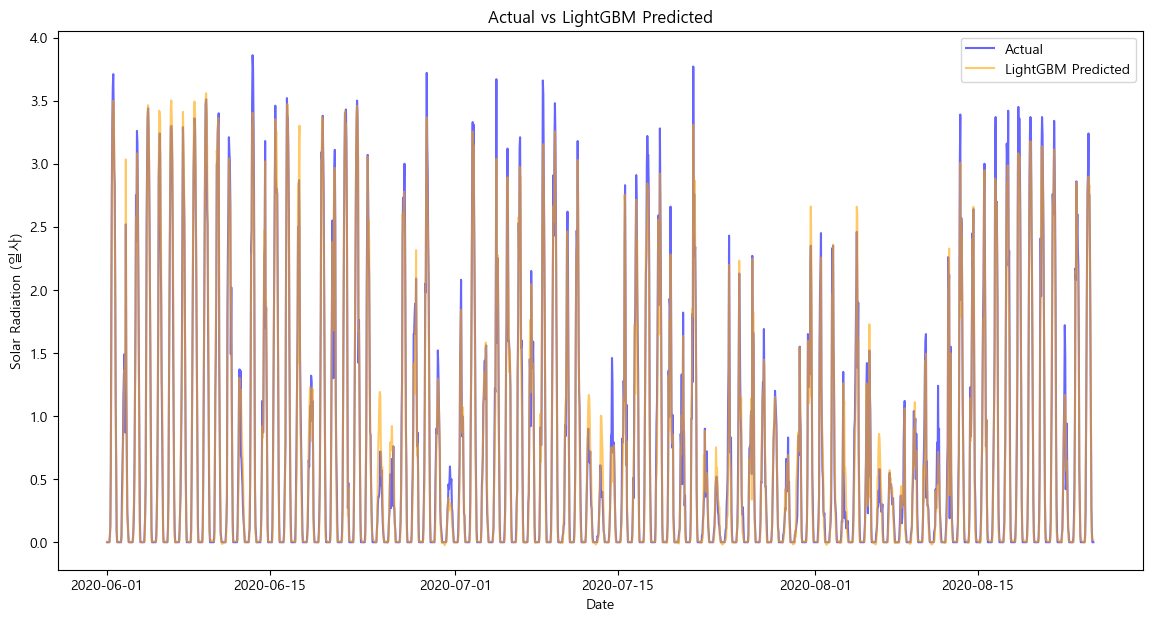

In [231]:
# 예측값과 실제값 비교 시각화
plt.figure(figsize=(14, 7))
plt.plot(test_SolarEnergy['일시'], y_test, label='Actual', color='blue', alpha=0.6)
plt.plot(test_SolarEnergy['일시'], lgbm_pred, label='LightGBM Predicted', color='orange', alpha=0.6)
plt.title('Actual vs LightGBM Predicted')
plt.xlabel('Date')
plt.ylabel('Solar Radiation (일사)')
plt.legend()
plt.show()

In [232]:
import matplotlib.dates as mdates

# 예측 기간을 6월 1일부터 5일까지로 설정
forecast_dates = pd.date_range(start='2020-06-01', periods=120, freq='H')

# 실제 관측 데이터 추출 (해당 날짜 범위 내 데이터만 사용)
actual_test_data = test_SolarEnergy.loc[test_SolarEnergy['일시'].between('2020-06-01', '2020-06-05'), '일사'].values

# 데이터 길이 조정
actual_length = len(actual_test_data)
forecast_df = forecast_df[:actual_length]  # SARIMA 예측 길이 맞추기
lgbm_forecast_data = lgbm_pred[:actual_length]  # LightGBM 예측 길이 맞추기
forecast_dates = forecast_dates[:actual_length]  # 날짜 길이 맞추기

# 예측 결과 시각화
plt.figure(figsize=(14, 8))

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1186716562.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_dates = pd.date_range(start='2020-06-01', periods=120, freq='H')


<Figure size 1400x800 with 0 Axes>

<Figure size 1400x800 with 0 Axes>

## 60개 건물 데이터에 적용

In [233]:
building_df.rename(columns={
    'date_time' : '일시'
}, inplace=True)

In [234]:
# 파생변수 만들기
building_df['year'] = building_df['일시'].dt.year
building_df['month'] = building_df['일시'].dt.month
building_df['hour'] = building_df['일시'].dt.hour

In [235]:
# '일시' 열을 인덱스로 설정하여 시간 순서에 따라 정렬
building_df.set_index('일시', inplace= True)

In [236]:
X_df = building_df[['기온', '강수량', '풍속', '습도', '일조', 'year', 'month', 'hour']]
y_pred = np.round(lgbm_model.predict(X_df), 2)
y_pred

array([0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ])

In [237]:
# 인덱스 리셋.
building_df.reset_index(inplace=True)

In [238]:
# 일사(MJ/m2)
building_df['예측일사(MJ/m2)'] = y_pred
building_df.columns

Index(['일시', 'num', '전력사용량', '기온', '풍속', '습도', '강수량', '일조', '비전기냉방설비운영',
       '태양광보유', '월', '일', '시', '날짜', '요일', '주말or평일', 'year', 'month', 'hour',
       '예측일사(MJ/m2)'],
      dtype='object')

In [239]:
building_df

,일시,num,전력사용량,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,월,일,시,날짜,요일,주말or평일,year,month,hour,예측일사(MJ/m2)
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,6,1,0,06/01,Monday,weekday,2020,6,0,0.00
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,6,1,1,06/01,Monday,weekday,2020,6,1,0.00
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,6,1,2,06/01,Monday,weekday,2020,6,2,0.01
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,6,1,3,06/01,Monday,weekday,2020,6,3,0.01
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,6,1,4,06/01,Monday,weekday,2020,6,4,0.01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,2020-08-24 19:00:00,60,4114.368,27.8,2.3,68.0,0.0,0.7,True,True,8,24,19,08/24,Monday,weekday,2020,8,19,0.53
122396,2020-08-24 20:00:00,60,3975.696,27.3,1.2,71.0,0.0,0.0,True,True,8,24,20,08/24,Monday,weekday,2020,8,20,0.02
122397,2020-08-24 21:00:00,60,3572.208,27.3,1.8,71.0,0.0,0.0,True,True,8,24,21,08/24,Monday,weekday,2020,8,21,0.00
122398,2020-08-24 22:00:00,60,3299.184,27.1,1.8,74.0,0.0,0.0,True,True,8,24,22,08/24,Monday,weekday,2020,8,22,0.00


In [243]:
new_df = building_df[['일시', 'num', '전력사용량', '태양광보유', '날짜', '시', '예측일사(MJ/m2)']]
new_df

,일시,num,전력사용량,태양광보유,날짜,시,예측일사(MJ/m2)
0,2020-06-01 00:00:00,1,8179.056,False,06/01,0,0.00
1,2020-06-01 01:00:00,1,8135.640,False,06/01,1,0.00
2,2020-06-01 02:00:00,1,8107.128,False,06/01,2,0.01
3,2020-06-01 03:00:00,1,8048.808,False,06/01,3,0.01
4,2020-06-01 04:00:00,1,8043.624,False,06/01,4,0.01
...,...,...,...,...,...,...,...
122395,2020-08-24 19:00:00,60,4114.368,True,08/24,19,0.53
122396,2020-08-24 20:00:00,60,3975.696,True,08/24,20,0.02
122397,2020-08-24 21:00:00,60,3572.208,True,08/24,21,0.00
122398,2020-08-24 22:00:00,60,3299.184,True,08/24,22,0.00


In [244]:
new_df['일사량(kW/m²)'] = new_df['예측일사(MJ/m2)'] * 0.27778
new_df.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1966984624.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['일사량(kW/m²)'] = new_df['예측일사(MJ/m2)'] * 0.27778


,일시,num,전력사용량,태양광보유,날짜,시,예측일사(MJ/m2),일사량(kW/m²)
0,2020-06-01 00:00:00,1,8179.056,False,06/01,0,0.00,0.000000
1,2020-06-01 01:00:00,1,8135.640,False,06/01,1,0.00,0.000000
2,2020-06-01 02:00:00,1,8107.128,False,06/01,2,0.01,0.002778
3,2020-06-01 03:00:00,1,8048.808,False,06/01,3,0.01,0.002778
4,2020-06-01 04:00:00,1,8043.624,False,06/01,4,0.01,0.002778


In [246]:
df_1 = new_df.groupby(['num', '날짜'], as_index= False)\
                     .agg(하루_전력사용량 = ('전력사용량', 'sum'),
                          하루_일사량 = ('일사량(kW/m²)', 'sum'),
                          태양광보유 = ('태양광보유', 'mean'))
df_1.head()


,num,날짜,하루_전력사용량,하루_일사량,태양광보유
0,1,06/01,193194.720,7.647283,0.0
1,1,06/02,190996.056,2.444464,0.0
2,1,06/03,198470.736,6.741721,0.0
3,1,06/04,203033.952,5.186153,0.0
4,1,06/05,206675.064,6.816721,0.0


In [247]:
df_2 = df_1.groupby('num', as_index= False)\
           .agg(총_전력사용량 = ('하루_전력사용량', 'sum'),
                총_일사량 = ('하루_일사량', 'sum'),
                태양광보유 = ('태양광보유', 'mean'))\
           .sort_values('총_일사량', ascending= False)
df_2.head()

,num,총_전력사용량,총_일사량,태양광보유
28,29,1.756591e+06,413.514419,0.0
3,4,1.558555e+06,410.608840,1.0
59,60,6.843735e+06,393.283702,1.0
41,42,7.394168e+06,393.283702,1.0
34,35,2.651912e+06,393.283702,0.0


In [248]:
df_2['태양광보유'] = np.where(df_2['태양광보유'] == 1, '유', '무')
df_2.head()

,num,총_전력사용량,총_일사량,태양광보유
28,29,1.756591e+06,413.514419,무
3,4,1.558555e+06,410.608840,유
59,60,6.843735e+06,393.283702,유
41,42,7.394168e+06,393.283702,유
34,35,2.651912e+06,393.283702,무


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400'),
  Text(0, 450.0, '450')])

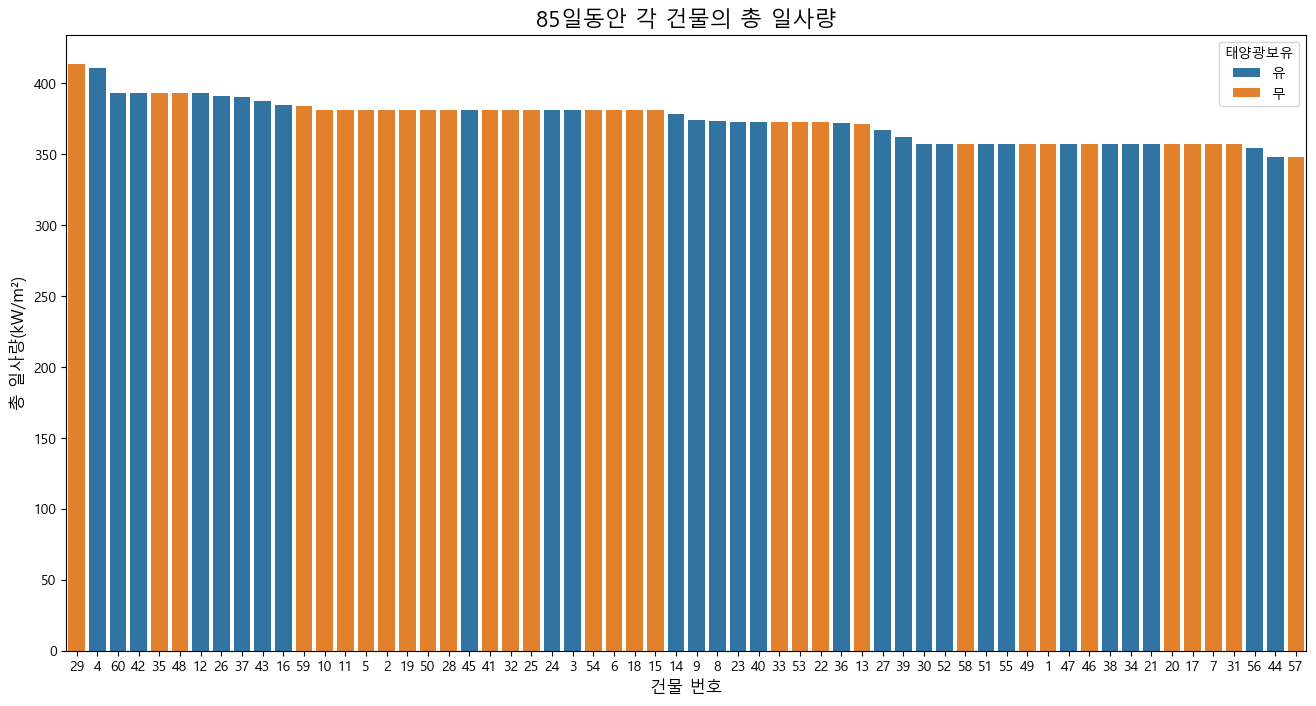

In [249]:
# 시각화
plt.figure(figsize=(16, 8))
sns.barplot(data = df_2, x = 'num', y = '총_일사량', hue = '태양광보유', order= df_2['num'], hue_order= '유무')
plt.title('85일동안 각 건물의 총 일사량', fontsize=16) # 그래프 제목 추가 및 글자 크기 설정
plt.xlabel('건물 번호', fontsize=12)
plt.ylabel('총 일사량(kW/m²)', fontsize=12)
plt.xticks(fontsize=10) # x축 레이블 글자 크기 설정
plt.yticks(fontsize=10) # y축 레이블 글자 크기 설정

In [250]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 60 entries, 28 to 56
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   num      60 non-null     object 
 1   총_전력사용량  60 non-null     float64
 2   총_일사량    60 non-null     float64
 3   태양광보유    60 non-null     object 
dtypes: float64(2), object(2)
memory usage: 2.3+ KB


In [251]:
# 태양광 보유하지 않았으면서 일사량이 높은 건물 top 3 테이블로 보기
df_3 = df_2.query('태양광보유 == "무"')\
           .head(3)
df_3

,num,총_전력사용량,총_일사량,태양광보유
28,29,1.756591e+06,413.514419,무
34,35,2.651912e+06,393.283702,무
47,48,2.331727e+06,393.283702,무


(array([  0.,  50., 100., 150., 200., 250., 300., 350., 400., 450.]),
 [Text(0, 0.0, '0'),
  Text(0, 50.0, '50'),
  Text(0, 100.0, '100'),
  Text(0, 150.0, '150'),
  Text(0, 200.0, '200'),
  Text(0, 250.0, '250'),
  Text(0, 300.0, '300'),
  Text(0, 350.0, '350'),
  Text(0, 400.0, '400'),
  Text(0, 450.0, '450')])

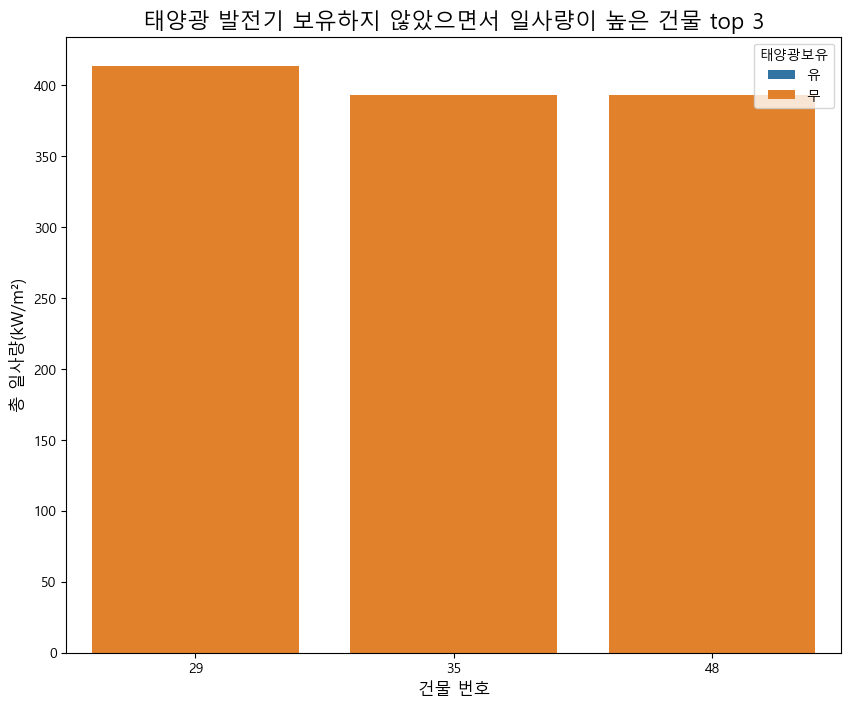

In [252]:
# 시각화
plt.figure(figsize=(10, 8))
sns.barplot(data = df_3, x = 'num', y = '총_일사량', hue = '태양광보유', order= df_3['num'], hue_order= '유무')
plt.title('태양광 발전기 보유하지 않았으면서 일사량이 높은 건물 top 3', fontsize=16) # 그래프 제목 추가 및 글자 크기 설정
plt.xlabel('건물 번호', fontsize=12)
plt.ylabel('총 일사량(kW/m²)', fontsize=12)
plt.xticks(fontsize=10) # x축 레이블 글자 크기 설정
plt.yticks(fontsize=10) # y축 레이블 글자 크기 설정

In [253]:
building_df.rename(columns={'date_time' : '일시', '예측일사(MJ/m2)': '예측일사_MJ', '전력사용량': '전력사용량_kWh'}, inplace=True)

building_df['일자'] = building_df['일시'].dt.date

MJ_to_kWh = 0.277778

is_solar = building_df.groupby(['num'],as_index=False).agg(태양광보유=('태양광보유','sum'))
is_solar['태양광보유'] = is_solar['태양광보유'].apply(lambda x: 1 if x > 0 else 0)

In [254]:
building_df

,일시,num,전력사용량_kWh,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,...,일,시,날짜,요일,주말or평일,year,month,hour,예측일사_MJ,일자
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,...,1,0,06/01,Monday,weekday,2020,6,0,0.00,2020-06-01
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,...,1,1,06/01,Monday,weekday,2020,6,1,0.00,2020-06-01
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,...,1,2,06/01,Monday,weekday,2020,6,2,0.01,2020-06-01
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,...,1,3,06/01,Monday,weekday,2020,6,3,0.01,2020-06-01
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,...,1,4,06/01,Monday,weekday,2020,6,4,0.01,2020-06-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
122395,2020-08-24 19:00:00,60,4114.368,27.8,2.3,68.0,0.0,0.7,True,True,...,24,19,08/24,Monday,weekday,2020,8,19,0.53,2020-08-24
122396,2020-08-24 20:00:00,60,3975.696,27.3,1.2,71.0,0.0,0.0,True,True,...,24,20,08/24,Monday,weekday,2020,8,20,0.02,2020-08-24
122397,2020-08-24 21:00:00,60,3572.208,27.3,1.8,71.0,0.0,0.0,True,True,...,24,21,08/24,Monday,weekday,2020,8,21,0.00,2020-08-24
122398,2020-08-24 22:00:00,60,3299.184,27.1,1.8,74.0,0.0,0.0,True,True,...,24,22,08/24,Monday,weekday,2020,8,22,0.00,2020-08-24


In [255]:
# 한화 큐셀 600W 태양관 모듈 * 250개 (1억 든다고 함) (실제 공장도 이렇게 600w 160개 하더라) 
# (청주 공장이라고 가정, 전기 사용량 많아서)

# 발전 효율 : 21.5% 
# 설치 면적 : 2.462 * 1.134 = 2.791908

efficiency = 0.215
area = 2.462 * 1.134
num = 250

building_df['예측일사_kWh'] = building_df['예측일사_MJ'] * MJ_to_kWh
building_df['예상_발전량_kWh'] = building_df['예측일사_kWh'] * area * num * efficiency
building_df
building_df.head()

,일시,num,전력사용량_kWh,기온,풍속,습도,강수량,일조,비전기냉방설비운영,태양광보유,...,날짜,요일,주말or평일,year,month,hour,예측일사_MJ,일자,예측일사_kWh,예상_발전량_kWh
0,2020-06-01 00:00:00,1,8179.056,17.6,2.5,92.0,0.8,0.0,False,False,...,06/01,Monday,weekday,2020,6,0,0.00,2020-06-01,0.000000,0.000000
1,2020-06-01 01:00:00,1,8135.640,17.7,2.9,91.0,0.3,0.0,False,False,...,06/01,Monday,weekday,2020,6,1,0.00,2020-06-01,0.000000,0.000000
2,2020-06-01 02:00:00,1,8107.128,17.5,3.2,91.0,0.0,0.0,False,False,...,06/01,Monday,weekday,2020,6,2,0.01,2020-06-01,0.002778,0.416848
3,2020-06-01 03:00:00,1,8048.808,17.1,3.2,91.0,0.0,0.0,False,False,...,06/01,Monday,weekday,2020,6,3,0.01,2020-06-01,0.002778,0.416848
4,2020-06-01 04:00:00,1,8043.624,17.0,3.3,92.0,0.0,0.0,False,False,...,06/01,Monday,weekday,2020,6,4,0.01,2020-06-01,0.002778,0.416848


In [256]:
building_df['절약요금'] = 0  # Initialize the column
building_df['일시'].dt.date.unique()
# Apply the conditions
building_df.loc[(building_df['hour'] == 11) | ((building_df['hour'] > 12) & (building_df['hour'] < 18)), '절약요금'] = building_df['예상_발전량_kWh'] * 229
building_df.loc[((building_df['hour'] > 21) | (building_df['hour'] < 8)), '절약요금'] = building_df['예상_발전량_kWh'] * 94
building_df.loc[((building_df['hour'] > 7) & (building_df['hour'] < 11)) | (building_df['hour'] == 12) | ((building_df['hour'] > 17) & (building_df['hour'] < 22)), '절약요금'] = building_df['예상_발전량_kWh'] * 146.9

building = building_df.groupby(['num'],as_index=False).agg(총_전력사용량_kWh=('전력사용량_kWh','sum'),
                                       총_예측일사_MJ=('예측일사_MJ','sum'),
                                       총_예측일사_kWh=('예측일사_kWh','sum'),
                                       총_예상발전량_kWh=('예상_발전량_kWh','sum'),
                                       총_절약요금=('절약요금','sum'))

building['발전비율'] = building['총_예상발전량_kWh'] / building['총_전력사용량_kWh']
building.head()

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\2279341055.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[29019.2700734  33028.51133354 32360.30445685 ... 26060.06819091
 21287.16192884 16132.4231658 ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  building_df.loc[(building_df['hour'] == 11) | ((building_df['hour'] > 12) & (building_df['hour'] < 18)), '절약요금'] = building_df['예상_발전량_kWh'] * 229


,num,총_전력사용량_kWh,총_예측일사_MJ,총_예측일사_kWh,총_예상발전량_kWh,총_절약요금,발전비율
0,1,1.742828e+07,1285.73,357.147508,53595.360422,1.053239e+07,0.003075
1,2,2.651825e+06,1371.85,381.069749,57185.252888,1.121939e+07,0.021564
2,3,6.877562e+06,1371.49,380.969749,57170.246370,1.128802e+07,0.008313
3,4,1.558555e+06,1478.18,410.605884,61617.594572,1.206701e+07,0.039535
4,5,5.537600e+06,1371.85,381.069749,57185.252888,1.121939e+07,0.010327


In [257]:
building = building.merge(is_solar, on='num', how='left')
building = building.sort_values('총_예측일사_kWh',ascending=False)
building['총_전력사용량_kWh'] = building['총_전력사용량_kWh'].astype(int)
building['총_절약요금'] = building['총_절약요금'].astype(int)
building.query('태양광보유==0').head(3)


building.head()
building['발전비율'] = building['발전비율'].astype(float)
building = building.applymap(lambda x: '{:.3f}'.format(x) if isinstance(x, float) else x)
building.head(3)

# 평균 건물당 절약요금
(12135025+11674297+11674297)/3

C:\Users\USER\AppData\Local\Temp\ipykernel_19300\1846223900.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  building = building.applymap(lambda x: '{:.3f}'.format(x) if isinstance(x, float) else x)


11827873.0